In [36]:
import os
import re
import sys
sys.path.append('../')
import json
import pywt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import simpson
from sklearn.linear_model import RidgeClassifierCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from tqdm import tqdm
from typing import List
from transform import TimeSeriesTransform
from concurrent.futures import ThreadPoolExecutor, as_completed

In [37]:
cfg = json.load(open("../config/config.json"))

ts_trans = TimeSeriesTransform(cfg)

In [38]:
INSTANCES_DIR = '../data/linear_acuator/instances/'
INFERENCE_DIR = '../data/linear_acuator/inference/'
STATES = ['normal', 
            'backlash1', 'backlash2',
            'lackLubrication1', 'lackLubrication2',
            'spalling1', 'spalling2', 'spalling3', 'spalling4', 'spalling5', 'spalling6', 'spalling7', 'spalling8']
LOADS= ['20kg', '40kg', '-40kg']

In [39]:
load = '20kg'
filenames_20kg = [os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES]
filenames_20kg = [filename for sublist in filenames_20kg for filename in sublist]

load = '40kg'
filenames_40kg = [os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES]
filenames_40kg = [filename for sublist in filenames_40kg for filename in sublist]

load = '-40kg'
filenames_m40kg = [os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES]
filenames_m40kg = [filename for sublist in filenames_m40kg for filename in sublist]

In [40]:
def get_X_y(filenames, load, is_train=True):
    X, y = [], []
    data_dir = INSTANCES_DIR if is_train else INFERENCE_DIR
    for filename in filenames:
        load_num = load[:-2]
        state = re.match(fr'(.*)_{load_num}', filename).group(1)
        df = pd.read_csv(os.path.join(data_dir, load, state, filename))
        tmp_cur = ts_trans.smoothing(ts_df=df, field='current')
        # tmp_pos = ts_transform.smoothing(ts_df=df, field='position_error')
        X.append(tmp_cur)
        y.append(state)
    return np.array(X), np.array(y)

In [41]:
X_20kg, y_20kg = get_X_y(filenames_20kg, load='20kg')
X_40kg, y_40kg = get_X_y(filenames_40kg, load='40kg')
X_m40kg, y_m40kg = get_X_y(filenames_m40kg, load='-40kg')

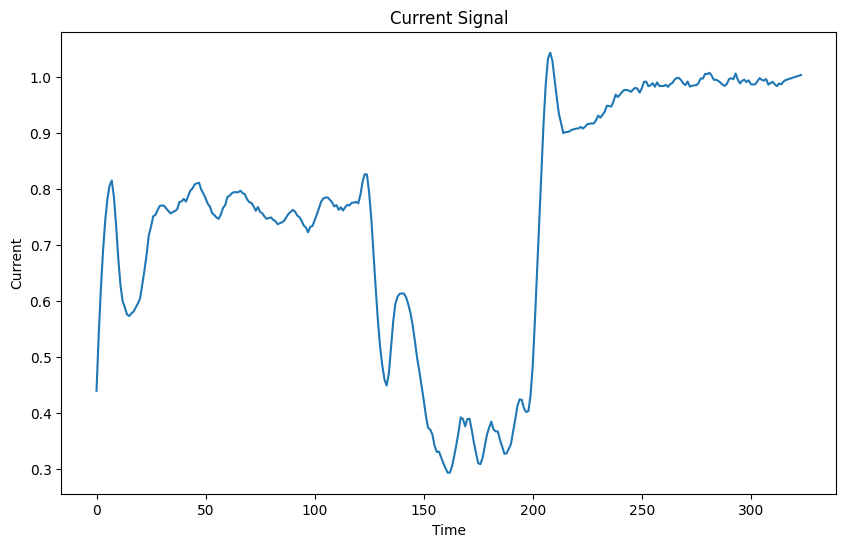

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(X_20kg[0])
plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Current Signal')
plt.show()

In [43]:
# Z-normalize the time series data
z_normalized_X_20kg = (X_20kg - np.mean(X_20kg, axis=1, keepdims=True)) / np.std(X_20kg, axis=1, keepdims=True)
z_normalized_X_40kg = (X_40kg - np.mean(X_40kg, axis=1, keepdims=True)) / np.std(X_40kg, axis=1, keepdims=True)
z_normalized_X_m40kg = (X_m40kg - np.mean(X_m40kg, axis=1, keepdims=True)) / np.std(X_m40kg, axis=1, keepdims=True)

In [44]:
minmax_X_20kg = 2 * (X_20kg - np.min(X_20kg, axis=1, keepdims=True)) / (np.max(X_20kg, axis=1, keepdims=True) - np.min(X_20kg, axis=1, keepdims=True)) - 1
minmax_X_40kg = 2 * (X_40kg - np.min(X_40kg, axis=1, keepdims=True)) / (np.max(X_40kg, axis=1, keepdims=True) - np.min(X_40kg, axis=1, keepdims=True)) - 1
minmax_X_m40kg = 2 * (X_m40kg - np.min(X_m40kg, axis=1, keepdims=True)) / (np.max(X_m40kg, axis=1, keepdims=True) - np.min(X_m40kg, axis=1, keepdims=True)) - 1

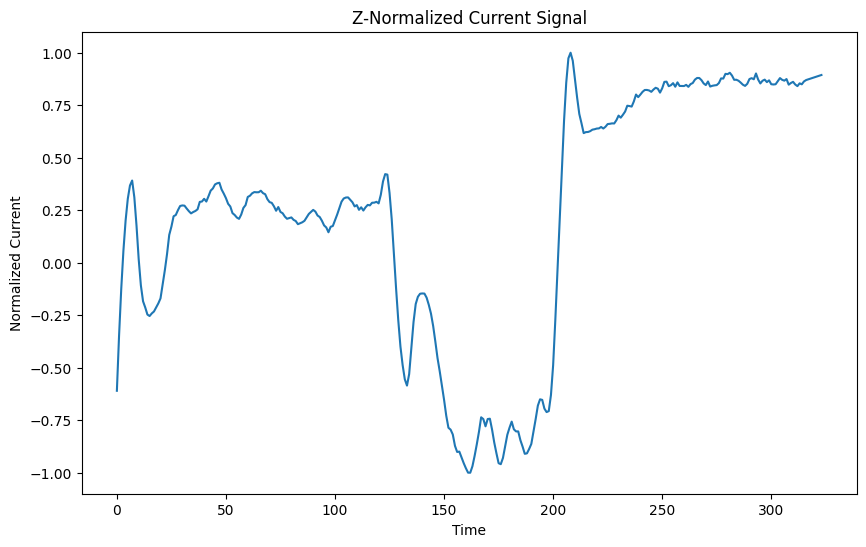

In [45]:
plt.figure(figsize=(10, 6))
plt.plot(minmax_X_20kg[0])
plt.xlabel('Time')
plt.ylabel('Normalized Current')
plt.title('Z-Normalized Current Signal')
plt.show()

In [46]:
lower_bound = 0.1   # Lower bound of the range (inclusive)
upper_bound = 100  # Upper bound of the range (exclusive)
n_kernels = 1000
np.random.seed(42)  # for reproducibility
random_scales = np.random.uniform(lower_bound, upper_bound, n_kernels)
wavelet = 'morl' 

In [47]:
coefficients, freqs = pywt.cwt(minmax_X_20kg[0], random_scales, wavelet, method='conv')
coefficients.shape

(1000, 324)

In [48]:
x_arr = np.arange(0, len(coefficients[0]))
x_arr = np.tile(x_arr, (coefficients.shape[0], 1))
x_arr.shape

(1000, 324)

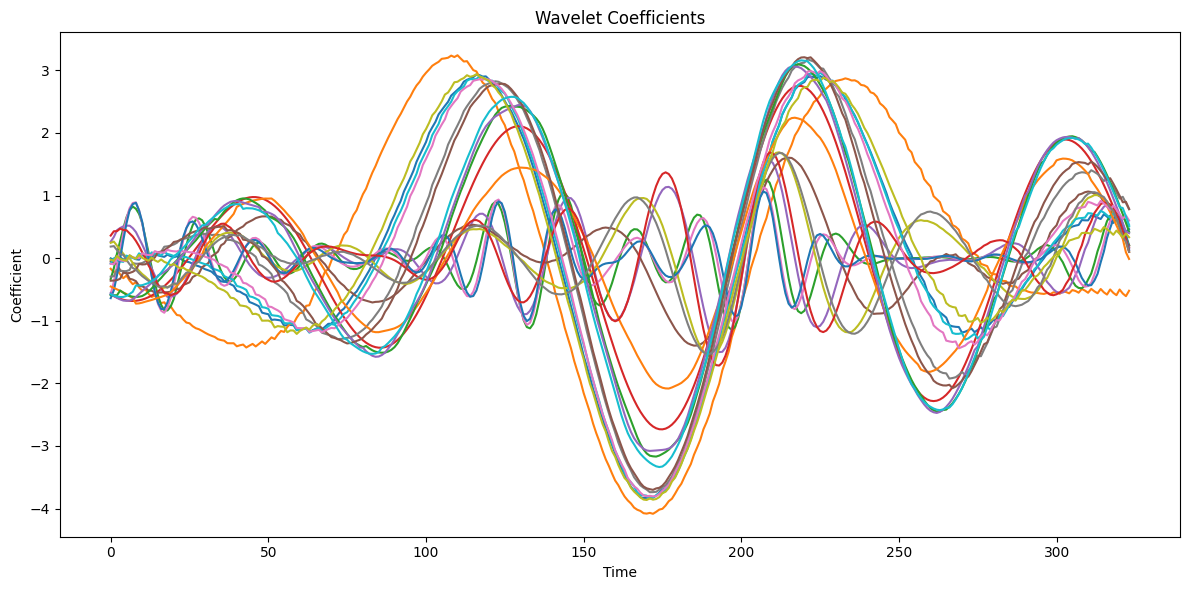

In [49]:
rand_idx = [np.random.randint(coefficients.shape[0]) for _ in range(20)]

plt.figure(figsize=(12, 6))
for i in range(20):
    plt.plot(x_arr[0], coefficients[rand_idx[i]])
    plt.xlabel('Time')
    plt.ylabel('Coefficient')
    plt.title('Wavelet Coefficients')

plt.tight_layout()
plt.show()

In [50]:
rms = np.sqrt(np.mean((minmax_X_20kg[0] - coefficients)**2, axis=1))
rms

array([0.78209142, 1.61171181, 1.58158821, 1.17295763, 0.67775893,
       0.67762112, 0.62416019, 1.49847674, 1.18701745, 1.56168017,
       0.62655799, 1.67402587, 1.51619834, 0.70157339, 0.68691863,
       0.68549443, 0.75994987, 0.81421611, 0.76583823, 0.76679116,
       1.24238201, 0.65897909, 0.76517747, 0.77601312, 0.73856821,
       1.56255853, 0.68873973, 0.7809681 , 1.1401515 , 0.62504107,
       1.21824173, 0.68640928, 0.62248424, 1.60718512, 1.66542003,
       1.539557  , 0.75652865, 0.63060044, 1.51824745, 0.75522564,
       0.64240812, 0.74032705, 0.62593811, 1.52530493, 0.76754288,
       1.45606226, 0.75281904, 0.7986815 , 0.90605357, 0.68566094,
       1.67379009, 1.56949181, 1.58241352, 1.50820889, 1.16898036,
       1.54385715, 0.62652561, 0.68740241, 0.62534924, 0.75146124,
       0.78880645, 0.77232111, 1.51886141, 0.76744252, 0.77017474,
       0.88664139, 0.66111733, 1.54515247, 0.6232614 , 1.7380781 ,
       1.57298495, 0.6888426 , 0.62669511, 1.5315574 , 1.56059

In [51]:
def raven(sample, random_scales, wavelet):
    coefficients, _ = pywt.cwt(sample, random_scales, wavelet, method='conv')
    x_arr = np.arange(0, len(coefficients[0]))
    x_arr = np.tile(x_arr, (coefficients.shape[0], 1))
    rms = np.sqrt(np.mean((sample - coefficients)**2, axis=1))
    return rms

def raven_parallel(X, random_scales, wavelet, max_workers=8):
    raven_results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(raven, X[i], random_scales, wavelet) for i in range(len(X))]
        for future in tqdm(futures):
            raven_results.append(future.result())
    return raven_results

In [52]:
raven_results_20kg_p = raven_parallel(minmax_X_20kg, random_scales, wavelet)
raven_results_20kg_np = np.array(raven_results_20kg_p)
print(raven_results_20kg_np.shape)

ridge_20 = RidgeClassifierCV()
ridge_20.fit(raven_results_20kg_np, y_20kg)

lda_20 = LDA()
lda_20.fit(raven_results_20kg_np, y_20kg)

print(f'Ridge 20kg: {ridge_20.score(raven_results_20kg_np, y_20kg)}')
print(f'LDA 20kg: {lda_20.score(raven_results_20kg_np, y_20kg)}')

100%|██████████| 455/455 [00:20<00:00, 21.76it/s]


(455, 1000)
Ridge 20kg: 0.5318681318681319
LDA 20kg: 0.9978021978021978


In [53]:
raven_results_40kg_p = raven_parallel(minmax_X_40kg, random_scales, wavelet)
raven_results_40kg_np = np.array(raven_results_40kg_p)
print(raven_results_40kg_np.shape)

ridge_40 = RidgeClassifierCV()
ridge_40.fit(raven_results_40kg_np, y_40kg)

lda_40 = LDA()
lda_40.fit(raven_results_40kg_np, y_40kg)

print(f'Ridge 40kg: {ridge_40.score(raven_results_40kg_np, y_40kg)}')
print(f'LDA 40kg: {lda_40.score(raven_results_40kg_np, y_40kg)}')

100%|██████████| 452/452 [00:20<00:00, 22.03it/s]


(452, 1000)
Ridge 40kg: 0.5265486725663717
LDA 40kg: 0.995575221238938


In [54]:
raven_results_m40kg_p = raven_parallel(minmax_X_m40kg, random_scales, wavelet)
raven_results_m40kg_np = np.array(raven_results_m40kg_p)
print(raven_results_m40kg_np.shape)

ridge_m40 = RidgeClassifierCV()
ridge_m40.fit(raven_results_m40kg_np, y_m40kg)

lda_m40 = LDA()
lda_m40.fit(raven_results_m40kg_np, y_m40kg)

print(f'Ridge -40kg: {ridge_m40.score(raven_results_m40kg_np, y_m40kg)}')
print(f'LDA -40kg: {lda_m40.score(raven_results_m40kg_np, y_m40kg)}')

  0%|          | 0/455 [00:00<?, ?it/s]

100%|██████████| 455/455 [00:20<00:00, 21.78it/s]


(455, 1000)
Ridge -40kg: 0.5252747252747253
LDA -40kg: 0.989010989010989


In [55]:
load = '20kg'
filenames_20kg_t = [os.listdir(os.path.join(INFERENCE_DIR, load, state)) for state in STATES]
filenames_20kg_t = [filename for sublist in filenames_20kg_t for filename in sublist]

load = '40kg'
filenames_40kg_t = [os.listdir(os.path.join(INFERENCE_DIR, load, state)) for state in STATES]
filenames_40kg_t = [filename for sublist in filenames_40kg_t for filename in sublist]

load = '-40kg'
filenames_m40kg_t = [os.listdir(os.path.join(INFERENCE_DIR, load, state)) for state in STATES]
filenames_m40kg_t = [filename for sublist in filenames_m40kg_t for filename in sublist]

In [56]:
X_20kg_t, y_20kg_t = get_X_y(filenames_20kg_t, load='20kg', is_train=False)
X_40kg_t, y_40kg_t = get_X_y(filenames_40kg_t, load='40kg', is_train=False)
X_m40kg_t, y_m40kg_t = get_X_y(filenames_m40kg_t, load='-40kg', is_train=False)

In [57]:
z_normalized_X_20kg_t = (X_20kg_t - np.mean(X_20kg_t, axis=1, keepdims=True)) / np.std(X_20kg_t, axis=1, keepdims=True)
z_normalized_X_40kg_t = (X_40kg_t - np.mean(X_40kg_t, axis=1, keepdims=True)) / np.std(X_40kg_t, axis=1, keepdims=True)
z_normalized_X_m40kg_t = (X_m40kg_t - np.mean(X_m40kg_t, axis=1, keepdims=True)) / np.std(X_m40kg_t, axis=1, keepdims=True)

In [58]:
minmax_X_20kg_t = 2 * (X_20kg_t - np.min(X_20kg_t, axis=1, keepdims=True)) / (np.max(X_20kg_t, axis=1, keepdims=True) - np.min(X_20kg_t, axis=1, keepdims=True)) - 1
minmax_X_40kg_t = 2 * (X_40kg_t - np.min(X_40kg_t, axis=1, keepdims=True)) / (np.max(X_40kg_t, axis=1, keepdims=True) - np.min(X_40kg_t, axis=1, keepdims=True)) - 1
minmax_X_m40kg_t = 2 * (X_m40kg_t - np.min(X_m40kg_t, axis=1, keepdims=True)) / (np.max(X_m40kg_t, axis=1, keepdims=True) - np.min(X_m40kg_t, axis=1, keepdims=True)) - 1

In [59]:
raven_results_20kg_t = raven_parallel(minmax_X_20kg_t, random_scales, wavelet)
raven_results_20kg_t_np = np.array(raven_results_20kg_t)
print(f'Ridge 20kg test: {ridge_20.score(raven_results_20kg_t_np, y_20kg_t)}')
print(f'LDA 20kg test: {lda_20.score(raven_results_20kg_t_np, y_20kg_t)}')

100%|██████████| 195/195 [00:08<00:00, 21.87it/s]

Ridge 20kg test: 0.38974358974358975
LDA 20kg test: 0.7230769230769231


In [60]:
raven_results_40kg_t = raven_parallel(minmax_X_40kg_t, random_scales, wavelet)
raven_results_40kg_t_np = np.array(raven_results_40kg_t)
print(f'Ridge 40kg test:{ridge_40.score(raven_results_40kg_t_np, y_40kg_t)}')
print(f'LDA 40kg test: {lda_40.score(raven_results_40kg_t_np, y_40kg_t)}')

100%|██████████| 193/193 [00:08<00:00, 21.79it/s]

Ridge 40kg test:0.40932642487046633
LDA 40kg test: 0.7772020725388601


In [61]:
raven_result_m40kg_t = raven_parallel(minmax_X_m40kg_t, random_scales, wavelet)
raven_result_m40kg_t_np = np.array(raven_result_m40kg_t)
print(f'Ridge -40kg test: {ridge_m40.score(raven_result_m40kg_t_np, y_m40kg_t)}')
print(f'LDA -40kg test: {lda_m40.score(raven_result_m40kg_t_np, y_m40kg_t)}')

100%|██████████| 195/195 [00:08<00:00, 21.83it/s]

Ridge -40kg test: 0.4307692307692308
LDA -40kg test: 0.7384615384615385


## Use ROCKET for Comparison

In [62]:
from pyts.transformation import ROCKET

rocket = ROCKET(random_state=0)

rocket.fit(X_20kg)

rocket_results_20kg = rocket.transform(X_20kg)
rocket_results_20kg_t = rocket.transform(X_20kg_t)
rocket_20 = RidgeClassifierCV()
lda_20_ = LDA()
rocket_20.fit(rocket_results_20kg, y_20kg)
lda_20_.fit(rocket_results_20kg, y_20kg)
print(f'20kg train Ridge: {rocket_20.score(rocket_results_20kg, y_20kg)}')
print(f'20kg test Ridge: {rocket_20.score(rocket_results_20kg_t, y_20kg_t)}')
print(f'20kg train LDA: {lda_20_.score(rocket_results_20kg, y_20kg)}')
print(f'20kg test LDA: {lda_20_.score(rocket_results_20kg_t, y_20kg_t)}')

20kg train Ridge: 0.9978021978021978
20kg test Ridge: 0.7076923076923077
20kg train LDA: 0.9054945054945055
20kg test LDA: 0.764102564102564


In [63]:
rocket.fit(X_40kg)

rocket_results_40kg = rocket.transform(X_40kg)
rocket_results_40kg_t = rocket.transform(X_40kg_t)
rocket_40 = RidgeClassifierCV()
lda_40_ = LDA()
rocket_40.fit(rocket_results_40kg, y_40kg)
lda_40_.fit(rocket_results_40kg, y_40kg)
print(f'40kg train: {rocket_40.score(rocket_results_40kg, y_40kg)}')
print(f'40kg test: {rocket_40.score(rocket_results_40kg_t, y_40kg_t)}')
print(f'40kg train LDA: {lda_40_.score(rocket_results_40kg, y_40kg)}')
print(f'40kg test LDA: {lda_40_.score(rocket_results_40kg_t, y_40kg_t)}')

40kg train: 1.0
40kg test: 0.7823834196891192
40kg train LDA: 0.14601769911504425
40kg test LDA: 0.12953367875647667


In [64]:
rocket.fit(X_m40kg)

rocket_results_m40kg = rocket.transform(X_m40kg)
rocket_results_m40kg_t = rocket.transform(X_m40kg_t)
rocket_m40 = RidgeClassifierCV()
lda_m40_ = LDA()
rocket_m40.fit(rocket_results_m40kg, y_m40kg)
lda_m40_.fit(rocket_results_m40kg, y_m40kg)
print(f'm40kg train: {rocket_m40.score(rocket_results_m40kg, y_m40kg)}')
print(f'-40kg test: {rocket_m40.score(rocket_results_m40kg_t, y_m40kg_t)}')
print(f'm40kg train LDA: {lda_m40_.score(rocket_results_m40kg, y_m40kg)}')
print(f'-40kg test LDA: {lda_m40_.score(rocket_results_m40kg_t, y_m40kg_t)}')

m40kg train: 1.0
-40kg test: 0.7230769230769231
m40kg train LDA: 0.865934065934066
-40kg test LDA: 0.6923076923076923
